# Downloading data from Google Drive

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import plotly.express as px
import plotly.graph_objs as go

from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score,  r2_score,  f1_score, classification_report,roc_curve,roc_auc_score


 
from sklearn import model_selection  # Kfold..
# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import warnings

pd.set_option('display.max_rows', 200) # to show more rows.
warnings.simplefilter('ignore')



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DF, Dataset : Saber_Combined_Preprocessed

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/data.csv')
df.head(2)

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_foreigner,period,your_consecutive,your_marital_status,your_student,your_country_resides,your_have_ethnicity,your_dept_resides,your_dept_code_resides,your_municipality_resides,your_municipality_code_resides,your_high_school_degree,your_tuition_cost_university,your_tuition_pymt_scholarship,your_tuition_pymt_credit,your_tuition_pymt_parents,your_tuition_pymt_yourself,fami_current_household_type,fami_is_the_head_family,fami_econ_dependents,fami_father_education,fami_mother_education,fami_father_occupation,fami_mother_occupation,fami_housing_stratum,fami_internet,fami_computer,fami_automobile,fami_num_books,inst_institution_code,inst_institution_name,your_prgm_academic,group_reference,your_prgm_municipality_code,your_prgm_municipality,your_prgm_department,...,fami_social_stratum_sisben,fami_house_members,fami_house_rooms,fami_house_floor,fami_washer,fami_microwave,fami_oven,fami_dvd,fami_monthly_family_income,your_currently_working,your_background,cole_saber_11_icfes_code,cole_saber_11_icfes_dane,cole_saber_11_icfes_name,cole_type,cole_nature,cole_calendar,cole_bilingual,cole_character,cole_dane_code_campus,cole_name_campus,cole_main_campus,cole_area_location,cole_journey,cole_municipality_code_location,cole_municipality_location,cole_dept_code_location,cole_dept_location,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,score_english_saber_11_category,optative_field_saber_11,score_optative_saber_11,optative_category_saber_11
0,TI,COLOMBIA,M,30/07/1996,NO,20134,EK201340233804,Single,STUDENT,COLOMBIA,No,BOYACA,15.0,GUATEQUE,15322.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Undergraduate Degree complete,Middle School complete,Profesional independiente,Profesional independiente,Stratum 3,Si,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,11001,BOGOTÁ D.C.,BOGOTA,...,Not classified by SISBEN,Four,Four,"Polished wood, tile, tablet, marble, carpet",Si,Si,Si,Si,Unknown,No,No,5207.0,1.153220e+11,I.E. VALLE DE TENZA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.153220e+11,I.E. VALLE DE TENZA - SEDE PRINCIPAL,YES,URBAN,MORNING,15322.0,GUATEQUE,15.0,BOYACA,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,SCORE_INTERDISC_ENVIRONMENT,49.0,UNK
1,CC,COLOMBIA,M,13/04/1994,NO,20133,EK201330220754,Single,STUDENT,COLOMBIA,No,AMAZONAS,91.0,LETICIA,91001.0,Academic Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Middle School complete,Technical School complete,Empleado de nivel auxiliar o administrativo,Self-employed,Stratum 2,No,Si,Si,Unknown,2106,DIRECCION NACIONAL DE ESCUELAS-BOGOTÁ D.C.,TECNICO PROFESIONAL EN SERVICIO DE POLICIA,TECNOLOGICO EN MILITAR Y POLICIAL,11001,BOGOTÁ D.C.,BOGOTA,...,Not classified by SISBEN,Five,Three,"Cement, gravel, brick",Si,No,No,Si,Between 2 and less than 3 SMLV,"Yes, 20 hours or more per week",No,38919.0,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA - SEDE PRINCIPAL,YES,URBAN,MORNING,91001.0,LETICIA,91.0,AMAZONAS,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,SCORE_DEEPEN_LANGUAGE,6.0,II


In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage after optimization is: 130.41 MB
Decreased by 17.7%


In [7]:
replace_dict = {'AGRICULTURAL, FORESTRY ENGINEERING':'AGRICULTURAL, FOREST ENGINEERING',
               'AGROINDUSTRIAL ENGINEERING, FOOD':'AGROINDUSTRIAL AND FOOD ENGINEERING',
               'TRAINING RELATED TO THE MILITARY OR POLICE FIELD':'MILITARY OR POLICE TRAINING',
               'NUTRITION AND DIET':'NUTRITION AND DIETETICS'}
df['your_undergraduate_core'] = df['your_undergraduate_core'].replace(replace_dict)

In [8]:
df = df[df['your_undergraduate_core'] != 'UNCLASSIFIED']
df = df[df['your_undergraduate_core'] != 'UNKNOWN']
df['your_undergraduate_core'].value_counts().count()


58

In [9]:
# dictionary of categorical variables
import urllib.request as urllib2
import ast
contents = str("")
for line in urllib2.urlopen("https://raw.githubusercontent.com/vcuspinera/Datasets/main/omdena/colombia-career-recommender-system/translate_cat.txt"):
    contents += str(line)[2:-3]
contents += "}"
char_to_replace = {
    "\\r": "", "\\": "", # characters
    "xc3x81": "Á", "xc3x89": "É", "xc3x8d": "Í", "xc3x93": "Ó", "xc3x9a": "Ú", "xc3x9c": "Ü", "xc3x91": "Ñ", # capital letters
    "xc3xa1": "á", "xc3xa9": "é", "xc3xad": "í", "xc3xb3": "ó", "xc3xba": "ú", "xc3xb1": "ñ" # lowercase letters
}
for key, value in char_to_replace.items():
    contents = contents.replace(key, value)
dic_cat = ast.literal_eval(contents)

In [10]:
# Add the undergraduate core field variable
df['your_undergraduate_core_field'] = df[['your_undergraduate_core']].replace(dic_cat['your_undergraduate_core_field'])
df.head()

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_foreigner,period,your_consecutive,your_marital_status,your_student,your_country_resides,your_have_ethnicity,your_dept_resides,your_dept_code_resides,your_municipality_resides,your_municipality_code_resides,your_high_school_degree,your_tuition_cost_university,your_tuition_pymt_scholarship,your_tuition_pymt_credit,your_tuition_pymt_parents,your_tuition_pymt_yourself,fami_current_household_type,fami_is_the_head_family,fami_econ_dependents,fami_father_education,fami_mother_education,fami_father_occupation,fami_mother_occupation,fami_housing_stratum,fami_internet,fami_computer,fami_automobile,fami_num_books,inst_institution_code,inst_institution_name,your_prgm_academic,group_reference,your_prgm_municipality_code,your_prgm_municipality,your_prgm_department,...,fami_house_members,fami_house_rooms,fami_house_floor,fami_washer,fami_microwave,fami_oven,fami_dvd,fami_monthly_family_income,your_currently_working,your_background,cole_saber_11_icfes_code,cole_saber_11_icfes_dane,cole_saber_11_icfes_name,cole_type,cole_nature,cole_calendar,cole_bilingual,cole_character,cole_dane_code_campus,cole_name_campus,cole_main_campus,cole_area_location,cole_journey,cole_municipality_code_location,cole_municipality_location,cole_dept_code_location,cole_dept_location,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,score_english_saber_11_category,optative_field_saber_11,score_optative_saber_11,optative_category_saber_11,your_undergraduate_core_field
0,TI,COLOMBIA,M,30/07/1996,NO,20134,EK201340233804,Single,STUDENT,COLOMBIA,No,BOYACA,15.0,GUATEQUE,15322.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Undergraduate Degree complete,Middle School complete,Profesional independiente,Profesional independiente,Stratum 3,Si,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,11001,BOGOTÁ D.C.,BOGOTA,...,Four,Four,"Polished wood, tile, tablet, marble, carpet",Si,Si,Si,Si,Unknown,No,No,5207.0,1.153220e+11,I.E. VALLE DE TENZA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.153220e+11,I.E. VALLE DE TENZA - SEDE PRINCIPAL,YES,URBAN,MORNING,15322.0,GUATEQUE,15.0,BOYACA,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,SCORE_INTERDISC_ENVIRONMENT,49.0,UNK,BUSINESS
1,CC,COLOMBIA,M,13/04/1994,NO,20133,EK201330220754,Single,STUDENT,COLOMBIA,No,AMAZONAS,91.0,LETICIA,91001.0,Academic Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Middle School complete,Technical School complete,Empleado de nivel auxiliar o administrativo,Self-employed,Stratum 2,No,Si,Si,Unknown,2106,DIRECCION NACIONAL DE ESCUELAS-BOGOTÁ D.C.,TECNICO PROFESIONAL EN SERVICIO DE POLICIA,TECNOLOGICO EN MILITAR Y POLICIAL,11001,BOGOTÁ D.C.,BOGOTA,...,Five,Three,"Cement, gravel, brick",Si,No,No,Si,Between 2 and less than 3 SMLV,"Yes, 20 hours or more per week",No,38919.0,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA - SEDE PRINCIPAL,YES,URBAN,MORNING,91001.0,LETICIA,91.0,AMAZONAS,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,SCORE_DEEPEN_LANGUAGE,6.0,II,SPORTS AND PHYSICAL TRAIN
2,CC,COLOMBIA,F,08/12/1991,NO,20134,EK201340246502,Single,STUDENT,COLOMBIA,No,RISARALDA,66.0,DOSQUEBRADAS,66170.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Elementary school incomplete,Elementary school incomplete,Other activity or occupation,Home,Stratum 2,No,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,66001,PEREIRA,RISARALDA,...,Five,Three,"Cement, gravel, brick",Si,Si,Si,Si,Less than 1 SMLV,No,Si,61424.0,1.660010e+11,IE AQUILINO BEDOYA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEM

In [11]:
df['your_undergraduate_core_field'].value_counts().count()

14

In [12]:
ENGINEERING_dict = {"INDUSTRIAL ENGINEERING":'ENGINEERING',
"ENVIRONMENTAL, SANITARY ENGINEERING":'ENGINEERING',
"CIVIL ENGINEERING":'ENGINEERING',
"COMPUTER SYSTEMS, TELEMATICS ENGINEERING":'ENGINEERING',
"MECHANICAL ENGINEERING":'ENGINEERING',
"ELECTRONIC ENGINEERING, TELECOMMUNICATIONS":'ENGINEERING',
"CHEMICAL ENGINEERING":'ENGINEERING',
"MINING, METALLURGY ENGINEERING":'ENGINEERING',
"OTHER ENGINEERING":'ENGINEERING',
"ELECTRICAL ENGINEERING":'ENGINEERING',
"AGROINDUSTRIAL AND FOOD ENGINEERING":'ENGINEERING',
"AGRONOMIC, LIVESTOCK ENGINEERING":'ENGINEERING',
"ADMINISTRATIVE ENGINEERING":'ENGINEERING',
"BIOMEDICAL ENGINEERING":'ENGINEERING',
"AGRICULTURAL, FOREST ENGINEERING":'ENGINEERING',
}


#df['your_undergraduate_core'] = df['your_undergraduate_core'].replace(ENGINEERING_dict)
#df['your_undergraduate_core'].value_counts()

# Building the Recommendation System

In [13]:
recsys_df = df.copy()
recsys_df.head()

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_foreigner,period,your_consecutive,your_marital_status,your_student,your_country_resides,your_have_ethnicity,your_dept_resides,your_dept_code_resides,your_municipality_resides,your_municipality_code_resides,your_high_school_degree,your_tuition_cost_university,your_tuition_pymt_scholarship,your_tuition_pymt_credit,your_tuition_pymt_parents,your_tuition_pymt_yourself,fami_current_household_type,fami_is_the_head_family,fami_econ_dependents,fami_father_education,fami_mother_education,fami_father_occupation,fami_mother_occupation,fami_housing_stratum,fami_internet,fami_computer,fami_automobile,fami_num_books,inst_institution_code,inst_institution_name,your_prgm_academic,group_reference,your_prgm_municipality_code,your_prgm_municipality,your_prgm_department,...,fami_house_members,fami_house_rooms,fami_house_floor,fami_washer,fami_microwave,fami_oven,fami_dvd,fami_monthly_family_income,your_currently_working,your_background,cole_saber_11_icfes_code,cole_saber_11_icfes_dane,cole_saber_11_icfes_name,cole_type,cole_nature,cole_calendar,cole_bilingual,cole_character,cole_dane_code_campus,cole_name_campus,cole_main_campus,cole_area_location,cole_journey,cole_municipality_code_location,cole_municipality_location,cole_dept_code_location,cole_dept_location,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,score_english_saber_11_category,optative_field_saber_11,score_optative_saber_11,optative_category_saber_11,your_undergraduate_core_field
0,TI,COLOMBIA,M,30/07/1996,NO,20134,EK201340233804,Single,STUDENT,COLOMBIA,No,BOYACA,15.0,GUATEQUE,15322.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Undergraduate Degree complete,Middle School complete,Profesional independiente,Profesional independiente,Stratum 3,Si,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,11001,BOGOTÁ D.C.,BOGOTA,...,Four,Four,"Polished wood, tile, tablet, marble, carpet",Si,Si,Si,Si,Unknown,No,No,5207.0,1.153220e+11,I.E. VALLE DE TENZA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.153220e+11,I.E. VALLE DE TENZA - SEDE PRINCIPAL,YES,URBAN,MORNING,15322.0,GUATEQUE,15.0,BOYACA,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,SCORE_INTERDISC_ENVIRONMENT,49.0,UNK,BUSINESS
1,CC,COLOMBIA,M,13/04/1994,NO,20133,EK201330220754,Single,STUDENT,COLOMBIA,No,AMAZONAS,91.0,LETICIA,91001.0,Academic Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Middle School complete,Technical School complete,Empleado de nivel auxiliar o administrativo,Self-employed,Stratum 2,No,Si,Si,Unknown,2106,DIRECCION NACIONAL DE ESCUELAS-BOGOTÁ D.C.,TECNICO PROFESIONAL EN SERVICIO DE POLICIA,TECNOLOGICO EN MILITAR Y POLICIAL,11001,BOGOTÁ D.C.,BOGOTA,...,Five,Three,"Cement, gravel, brick",Si,No,No,Si,Between 2 and less than 3 SMLV,"Yes, 20 hours or more per week",No,38919.0,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA - SEDE PRINCIPAL,YES,URBAN,MORNING,91001.0,LETICIA,91.0,AMAZONAS,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,SCORE_DEEPEN_LANGUAGE,6.0,II,SPORTS AND PHYSICAL TRAIN
2,CC,COLOMBIA,F,08/12/1991,NO,20134,EK201340246502,Single,STUDENT,COLOMBIA,No,RISARALDA,66.0,DOSQUEBRADAS,66170.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Elementary school incomplete,Elementary school incomplete,Other activity or occupation,Home,Stratum 2,No,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,66001,PEREIRA,RISARALDA,...,Five,Three,"Cement, gravel, brick",Si,Si,Si,Si,Less than 1 SMLV,No,Si,61424.0,1.660010e+11,IE AQUILINO BEDOYA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEM

In [ ]:
# recsys_df.to_csv('/content/drive/MyDrive/Datasets/filter_data.csv',index=False)
recsys_df

,your_type_of_document,your_nationality,your_gender,your_birthdate,your_foreigner,period,your_consecutive,your_marital_status,your_student,your_country_resides,your_have_ethnicity,your_dept_resides,your_dept_code_resides,your_municipality_resides,your_municipality_code_resides,your_high_school_degree,your_tuition_cost_university,your_tuition_pymt_scholarship,your_tuition_pymt_credit,your_tuition_pymt_parents,your_tuition_pymt_yourself,fami_current_household_type,fami_is_the_head_family,fami_econ_dependents,fami_father_education,fami_mother_education,fami_father_occupation,fami_mother_occupation,fami_housing_stratum,fami_internet,fami_computer,fami_automobile,fami_num_books,inst_institution_code,inst_institution_name,your_prgm_academic,group_reference,your_prgm_municipality_code,your_prgm_municipality,your_prgm_department,...,fami_house_members,fami_house_rooms,fami_house_floor,fami_washer,fami_microwave,fami_oven,fami_dvd,fami_monthly_family_income,your_currently_working,your_background,cole_saber_11_icfes_code,cole_saber_11_icfes_dane,cole_saber_11_icfes_name,cole_type,cole_nature,cole_calendar,cole_bilingual,cole_character,cole_dane_code_campus,cole_name_campus,cole_main_campus,cole_area_location,cole_journey,cole_municipality_code_location,cole_municipality_location,cole_dept_code_location,cole_dept_location,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,score_english_saber_11_category,optative_field_saber_11,score_optative_saber_11,optative_category_saber_11,your_undergraduate_core_field
0,TI,COLOMBIA,M,30/07/1996,NO,20134,EK201340233804,Single,STUDENT,COLOMBIA,No,BOYACA,15.0,GUATEQUE,15322.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Undergraduate Degree complete,Middle School complete,Profesional independiente,Profesional independiente,Stratum 3,Si,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,11001,BOGOTÁ D.C.,BOGOTA,...,Four,Four,"Polished wood, tile, tablet, marble, carpet",Si,Si,Si,Si,Unknown,No,No,5207.0,1.153220e+11,I.E. VALLE DE TENZA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.153220e+11,I.E. VALLE DE TENZA - SEDE PRINCIPAL,YES,URBAN,MORNING,15322.0,GUATEQUE,15.0,BOYACA,32.0,43.0,39.0,42.0,33.0,33.0,29.0,38.0,A-,SCORE_INTERDISC_ENVIRONMENT,49.0,UNK,BUSINESS
1,CC,COLOMBIA,M,13/04/1994,NO,20133,EK201330220754,Single,STUDENT,COLOMBIA,No,AMAZONAS,91.0,LETICIA,91001.0,Academic Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Middle School complete,Technical School complete,Empleado de nivel auxiliar o administrativo,Self-employed,Stratum 2,No,Si,Si,Unknown,2106,DIRECCION NACIONAL DE ESCUELAS-BOGOTÁ D.C.,TECNICO PROFESIONAL EN SERVICIO DE POLICIA,TECNOLOGICO EN MILITAR Y POLICIAL,11001,BOGOTÁ D.C.,BOGOTA,...,Five,Three,"Cement, gravel, brick",Si,No,No,Si,Between 2 and less than 3 SMLV,"Yes, 20 hours or more per week",No,38919.0,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEMIC,1.910010e+11,I.E. INEM JOSE EUSTASIO RIVERA - SEDE PRINCIPAL,YES,URBAN,MORNING,91001.0,LETICIA,91.0,AMAZONAS,48.0,64.0,52.0,52.0,54.0,44.0,47.0,51.0,A1,SCORE_DEEPEN_LANGUAGE,6.0,II,SPORTS AND PHYSICAL TRAIN
2,CC,COLOMBIA,F,08/12/1991,NO,20134,EK201340246502,Single,STUDENT,COLOMBIA,No,RISARALDA,66.0,DOSQUEBRADAS,66170.0,Technical Bachelor,Did not pay tuition,No,No,Si,No,It is habitual or permanent,No,None,Elementary school incomplete,Elementary school incomplete,Other activity or occupation,Home,Stratum 2,No,No,No,Unknown,9110,SERVICIO NACIONAL DE APRENDIZAJE-SENA,TECNOLOGÍA EN CONTABILIDAD Y FINANZAS,TECNOLOGICO EN ADMINISTRACIÓN Y TURISMO,66001,PEREIRA,RISARALDA,...,Five,Three,"Cement, gravel, brick",Si,Si,Si,Si,Less than 1 SMLV,No,Si,61424.0,1.660010e+11,IE AQUILINO BEDOYA,MIXED,OFFICIAL,A,N,TECHNICAL/ACADEM

In [14]:
# Final features
features_train = [
      'score_language_saber_11',
      'score_mathematics_saber_11',
      'score_biology_saber_11',
      'score_chemistry_saber_11',
      'score_physics_saber_11',
      'score_social_science_saber_11',
      'score_philosophy_saber_11',
      'score_english_saber_11',
      # target
      'your_undergraduate_core',
      'your_undergraduate_core_field'
]

other_features = list(recsys_df.columns.drop(features_train))

In [15]:
recsys = recsys_df[features_train]
# recsys.head()

In [16]:
# Final features
features = [
      'score_language_saber_11',
      'score_mathematics_saber_11',
      'score_biology_saber_11',
      'score_chemistry_saber_11',
      'score_physics_saber_11',
      'score_social_science_saber_11',
      'score_philosophy_saber_11',
      'score_english_saber_11',
]
# for var in features:
#     print(var.upper() + ' Distribution')
#     print(recsys[var].describe())
#     print('-----')


In [17]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

In [18]:
for f in features:
  recsys[f] = qt.fit_transform(recsys[[f]].values.reshape(-1,1))

In [ ]:
# for var in features:
#     print(var.upper() + ' Distribution')
#     print(recsys[var].describe())
#     print('-----')

In [19]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = recsys['your_undergraduate_core'].unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
# idx2class

In [20]:
recsys['target_career_minor'] = recsys['your_undergraduate_core'].replace(class2idx)
# recsys.head()

In [21]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labelsM = recsys['your_undergraduate_core_field'].unique()
i = 0
idx2classM = {} 
class2idxM = {}
for tp in labelsM:
    idx2classM[i] = tp
    class2idxM[tp] = i
    i += 1
idx2classM

{0: 'BUSINESS',
 1: 'SPORTS AND PHYSICAL TRAIN',
 2: 'ENGINEERING',
 3: 'AGRONOMIC, LIVESTOCK ENGINEERING',
 4: 'HUMANITIES AND SOCIAL SCIENCE',
 5: 'MATH AND PHYSICAL SCIENCES',
 6: 'NUTRITION AND DIETETICS',
 7: 'HEALTH & MEDICINE',
 8: 'ARTS AND DESIGN',
 9: 'BIOLOGICAL SCIENCE',
 10: 'AGRICULTURAL, FOREST ENGINEERING',
 11: 'PLASTIC ARTS, VISUAL ARTS',
 12: 'PLASTIC, VISUAL ARTS',
 13: 'PHISICS'}

In [22]:
recsys['target_career_major'] = recsys['your_undergraduate_core_field'].replace(class2idxM)
# recsys.head()

In [49]:
# Final features
features_tr = [
      'score_language_saber_11',
      'score_mathematics_saber_11',
      'score_biology_saber_11',
      'score_chemistry_saber_11',
      'score_physics_saber_11',
      'score_social_science_saber_11',
      'score_philosophy_saber_11',
      'score_english_saber_11',
      # target
    # 'target_career_minor',
     'target_career_major'
]

df1 = recsys[features_tr]
df1.head(2)

,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,target_career_major
0,-2.611328,-0.723145,-1.333984,-1.107422,-1.755859,-2.003906,-1.811523,-1.342773,0
1,-0.475098,1.013672,0.358887,0.304443,0.631836,-0.668945,0.214600,0.244751,1


#Explaination of the process


1.   We have 14 categories to classify
2.   I divided 14 categories into 2 (group of 6 and 8) making their values as 0 and 1
3.   Same I did with those 6 and 8 categories, divided them into (2,4) and (4,4)respectively giving values 0 and 1 to both groups
4.   Sub divided these categories till i get 14 categories with 0 and 1 values
5.   This makes the model to predict 4 classes at once [b,b,b,b] each b predicts the group which fits the best
6.  With this approach the output categories are reduced to 4 classes



In [128]:
#2,3,4,11,12,13 --> 0
#0,1,5,6,7,8,9,10-->1
df1 = recsys[features_tr]

In [238]:
truth_table = [
    [1,0,0,0],
    [1,0,0,1],
    [0,0,0,0],
    [0,0,1,1],
    [0,1,0,0],
    [1,0,1,0],
    [1,0,1,1],
    [1,1,0,0],
    [1,1,0,1],
    [1,1,1,0],
    [1,1,1,1],
    [0,1,0,1],
    [0,1,1,0],
    [0,1,1,1]
]
len(truth_table)

14

In [129]:
rep_0_6 = {
      0:1,
      1:1,
      2:0,
      3:0,
      4:0,
      5:1,
      6:1,
      7:1,
      8:1,
      9:1,
      10:1,
      11:0,
      12:0,
      13:0
}

In [137]:
df1['2_classes'] = df1['target_career_major'].replace(rep_0_6)

In [140]:
#2,3 --> 0
#4,11,12,13-->1
#0,1,5,6 -->0
#7,8,9,10 -->1

rep_class_4 = {
    2:0,
    3:0,
    4:1,
    11:1,
    12:1,
    13:1,

    #other2 class
    0:0,
    1:0,
    5:0,
    6:0,
    7:1,
    8:1,
    9:1,
    10:1,
}

In [144]:
df1['4_classes'] = df1['target_career_major'].replace(rep_class_4)

In [146]:
#2->0 , 3->1
#4,11 ->0, 12,13-->1
#0,1-->0, 5,6-->1
#7,8-->0, 9,10-->1

rep_class_8 ={
    2:0,
    3:1,

    4:0,
    11:0,
    12:1,
    13:1,

    0:0,
    1:0,
    5:1,
    6:1,

    7:0,
    8:0,
    9:1,
    10:1
}

In [ ]:
df1['8_classes'] = df1['target_career_major'].replace(rep_class_8)
df1

In [148]:
#2->0, 3->1
#4->0, 11->1
#12->0, 13->1
#0->0, 1->1
#5->0, 6->1
#7->0, 8->1
#9->0, 10->1

rep_class_14 = {
    2:0,
    3:1,
    4:0,
    11:1,
    12:0,
    13:1,
    0:0,
    1:1,
    5:0,
    6:1,
    7:0,
    8:1,
    9:0,
    10:1
}

In [149]:
df1['14_classes'] = df1['target_career_major'].replace(rep_class_14)
df1

,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11,target_career_major,2_classes,4_classes,8_classes,14_classes
0,-2.611328,-0.723145,-1.333984,-1.107422,-1.755859,-2.003906,-1.811523,-1.342773,0,1,0,0,0
1,-0.475098,1.013672,0.358887,0.304443,0.631836,-0.668945,0.214600,0.244751,1,1,0,0,1
2,0.753418,-0.860840,0.101746,0.168457,-2.226562,-0.424805,-0.037964,-0.536133,0,1,0,0,0
3,-1.571289,-0.430908,-1.985352,-2.085938,-0.379150,-0.930176,-0.589355,-0.536133,0,1,0,0,0
4,-0.475098,-0.628906,0.920410,1.614258,-0.512207,-0.071655,-0.209595,-0.795410,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212005,-0.475098,0.263672,-0.023865,0.532227,1.914062,0.414307,0.783203,0.665527,2,0,0,0,0
212006,2.660156,2.207031,2.095703,0.770020,0.710449,1.155273,-0.351074,1.261719,7,1,1,0,0
212007,0.053894,-1.490234,-0.842773,-2.748047,-0.263672,-1.192383,-1.239258,-1.342773,0,1,0,0,0
212008,-0.475098,-0.056335,-0.949707,-0.503418,-0.379150,-0.668945,-1.404297,-0.536133,2,0,0,0,0


In [ ]:
#!pip install imblearn
#!pip install delayed

# Neural Network

In [150]:
# multi-class classification with Keras
import tensorflow as tf
#import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, UpSampling2D, MaxPooling2D, Conv2D, Input, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from nltk import flatten


In [151]:
X_train = df1.drop(['target_career_major','2_classes','4_classes','8_classes','14_classes'], axis=1)
X_train

,score_language_saber_11,score_mathematics_saber_11,score_biology_saber_11,score_chemistry_saber_11,score_physics_saber_11,score_social_science_saber_11,score_philosophy_saber_11,score_english_saber_11
0,-2.611328,-0.723145,-1.333984,-1.107422,-1.755859,-2.003906,-1.811523,-1.342773
1,-0.475098,1.013672,0.358887,0.304443,0.631836,-0.668945,0.214600,0.244751
2,0.753418,-0.860840,0.101746,0.168457,-2.226562,-0.424805,-0.037964,-0.536133
3,-1.571289,-0.430908,-1.985352,-2.085938,-0.379150,-0.930176,-0.589355,-0.536133
4,-0.475098,-0.628906,0.920410,1.614258,-0.512207,-0.071655,-0.209595,-0.795410
...,...,...,...,...,...,...,...,...
212005,-0.475098,0.263672,-0.023865,0.532227,1.914062,0.414307,0.783203,0.665527
212006,2.660156,2.207031,2.095703,0.770020,0.710449,1.155273,-0.351074,1.261719
212007,0.053894,-1.490234,-0.842773,-2.748047,-0.263672,-1.192383,-1.239258,-1.342773
212008,-0.475098,-0.056335,-0.949707,-0.503418,-0.379150,-0.668945,-1.404297,-0.536133


In [156]:
Y_train = np.array(df1[['2_classes','4_classes','8_classes','14_classes']])

In [ ]:
# def get_conv():
#   model = Sequential()
#   model.add(Conv2D(16, (2, 2), activation='relu', padding='same', input_shape=(4,2,1)))
#   model.add(UpSampling2D((2,3)))
#   model.add(UpSampling2D((2,3)))
#   model.add(BatchNormalization())
#   model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(Flatten())
#   model.add(Dense(32, activation='relu'))
#   model.add(Dense(4, activation='softmax'))
#   model.summary()
#   return model

# get_conv()

In [224]:
def get_model(act="relu"):
  # create model
  model = Sequential()
  model.add(Dense(14, input_dim=8, activation=act))
  model.add(BatchNormalization())
  model.add(Flatten())

  model.add(Dense(100, activation=act))
  model.add(BatchNormalization())

  model.add(Dense(100, activation=act))
  model.add(BatchNormalization())

  model.add(Dense(100, activation=act))
  model.add(BatchNormalization())
  

  model.add(Dense(100, activation=act))
  model.add(BatchNormalization())

  model.add(Dense(4, activation='sigmoid'))
  model.summary()
  return model


In [225]:
# Metrics 
model = None
model = get_model()

METRICS = [
            tf.keras.metrics.CategoricalAccuracy(name='categorical_acc'),
            # # tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            # 'AUC',
            # tf.keras.metrics.AUC(name='precision-recall_curve', curve='PR'), # precision-recall curve
            # 'top_k_categorical_accuracy',
            # tf.keras.metrics.Precision(name="precision@5",top_k=5),
            # tf.keras.metrics.Recall(name="recall@5",top_k=5)]
]
# Compile model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='SGD', metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 14)                126       
_________________________________________________________________
batch_normalization_40 (Batc (None, 14)                56        
_________________________________________________________________
flatten_14 (Flatten)         (None, 14)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               1500      
_________________________________________________________________
batch_normalization_41 (Batc (None, 100)               400       
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_42 (Batc (None, 100)             

In [263]:
#trained for more than 150 epochs
history = model.fit(X_train, Y_train, shuffle=True, validation_split=0.2 ,epochs=10,batch_size=512,verbose=1)

Epoch 1/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6182 - val_loss: 0.1510 - val_accuracy: 0.6109
Epoch 2/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6183 - val_loss: 0.1510 - val_accuracy: 0.6109
Epoch 3/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6188 - val_loss: 0.1510 - val_accuracy: 0.6108
Epoch 4/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6177 - val_loss: 0.1510 - val_accuracy: 0.6106
Epoch 5/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6185 - val_loss: 0.1510 - val_accuracy: 0.6097
Epoch 6/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6177 - val_loss: 0.1510 - val_accuracy: 0.6100
Epoch 7/10
318/318 [==============================] - 3s 10ms/step - loss: 0.1489 - accuracy: 0.6174 - val_loss: 0.1510 - val_accuracy: 0.6099

In [266]:
print('----Model--------------------------------- \n')
print('------------\n')
print('Model Binary Accuracy = {}'.format(history.history['accuracy'][np.argmin(history.history['loss'])]*100))
# print('Model TOP 5 Accuracy = {}'.format(history.history['top_k_categorical_accuracy'][np.argmin(history.history['loss'])]*100))
# print('Model AUC = {}'.format(history.history['auc'][np.argmin(history.history['loss'])]*100))
# print('Model AUC-PRCure = {}'.format(history.history['precision-recall_curve'][np.argmin(history.history['loss'])]*100))
# print('Model Precision = {}'.format(history.history['precision@5'][np.argmin(history.history['loss'])]*100))
# print('Model Recall = {}'.format(history.history['recall@5'][np.argmin(history.history['loss'])]*100))
# print('Model loss RMSE  = {}'.format(history.history['loss'][np.argmin(history.history['loss'])]))

----Model--------------------------------- 

------------

Model Binary Accuracy = 61.86791658401489


In [178]:
# Evaluation on Vali
model.evaluate(X_train,Y_train)

6357/6357 [==============================] - 8s 1ms/step - loss: 1.0848 - categorical_acc: 0.6543


[1.0847655534744263, 0.6543393135070801]

In [251]:
pred_x = model.predict(X_train)
pred_x[0]

array([0.55504227, 0.3415997 , 0.05803794, 0.15172794], dtype=float32)

In [257]:
pred_a = list(np.round(pred_x[0]).astype('int'))
pred_a

[1, 0, 0, 0]

In [261]:
idx2classM[truth_table.index(pred_a)]

'BUSINESS'

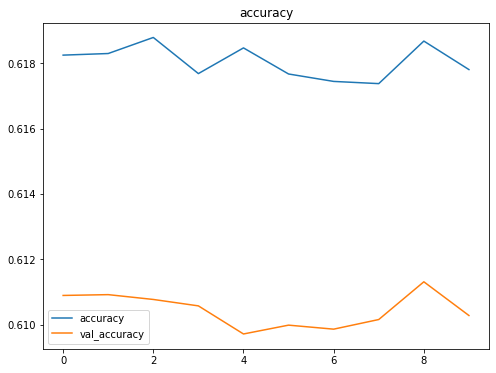

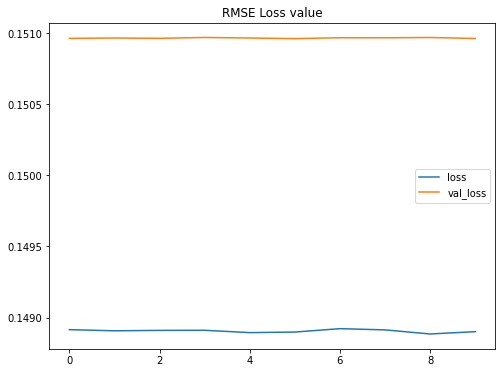

In [267]:
plt.figure(figsize=(8,6))
plt.title('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

# plt.figure(figsize=(8,6))
# plt.title('precision-recall_curve value')
# plt.plot(history.history['precision-recall_curve'])
# plt.plot(history.history['val_precision-recall_curve'])
# plt.legend(['prc', 'val_precision-recall_curve'])

# plt.figure(figsize=(8,6))
# plt.title('AUC value')
# plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
# plt.legend(['auc', 'val_auc'])

# plt.figure(figsize=(8,6))
# plt.title('top_k_categorical_accuracy value')
# plt.plot(history.history['top_k_categorical_accuracy'])
# plt.plot(history.history['val_top_k_categorical_accuracy'])
# plt.legend(['top_k_categorical_accuracy', 'val_top_k_categorical_accuracy'])

# plt.figure(figsize=(8,6))
# plt.title('Precision@5 value')
# plt.plot(history.history['precision@5'])
# plt.plot(history.history['val_precision@5'])
# plt.legend(['precision', 'val_precision@5'])


# plt.figure(figsize=(8,6))
# plt.title('Recall@5 value')
# plt.plot(history.history['recall@5'])
# plt.plot(history.history['val_recall@5'])
# plt.legend(['recall', 'val_recall@5'])


plt.figure(figsize=(8,6))
plt.title('RMSE Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()